# Unsupervised generative PC on MNIST

This notebook demonstrates how to train a neural network with predictive coding to encode MNIST digits in an unsupervised manner.

In [1]:
%%capture
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install matplotlib==3.0.0

In [2]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Hyperparameters

We define some global parameters, including network architecture, learning rate, batch size etc.

In [3]:
SEED = 0

LAYER_SIZES = [50, 100, 100, 784]
ACT_FN = "relu"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
T1 = 100
N_TRAIN_ITERS = 300

## Dataset

Some utils to fetch and plot MNIST.

In [4]:
#@title data utils


def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img = torch.flatten(img)
        return img


## Plotting

In [5]:
def plot_train_energies(train_energies, ts):
    t_max = int(ts[0])
    norm = mcolors.Normalize(vmin=0, vmax=len(energies)-1)
    fig, ax = plt.subplots(figsize=(8, 4))
    
    cmap_blues = plt.get_cmap("Blues")
    cmap_reds = plt.get_cmap("Reds")
    cmap_greens = plt.get_cmap("Greens")
    
    legend_handles = []
    legend_labels = []
    
    for t, energies_iter in enumerate(energies):
        line1, = ax.plot(energies_iter[0, :t_max], color=cmap_blues(norm(t)))
        line2, = ax.plot(energies_iter[1, :t_max], color=cmap_reds(norm(t)))
        line3, = ax.plot(energies_iter[2, :t_max], color=cmap_greens(norm(t)))
    
        if t == 70:
            legend_handles.append(line1)
            legend_labels.append("$\ell_1$")
            legend_handles.append(line2)
            legend_labels.append("$\ell_2$")
            legend_handles.append(line3)
            legend_labels.append("$\ell_3$")
    
    ax.legend(legend_handles, legend_labels, loc="best", fontsize=16)
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("Greys"), norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Training iteration", fontsize=16, labelpad=14)
    cbar.ax.tick_params(labelsize=14) 
    plt.gca().tick_params(axis="both", which="major", labelsize=16)
    
    ax.set_xlabel("Inference iterations", fontsize=18, labelpad=14)
    ax.set_ylabel("Energy", fontsize=18, labelpad=14)
    ax.set_yscale("log")
    plt.show()

## Network

For `jpc` to work, we need to provide a network with callable layers. This is easy to do with the PyTorch-like `nn.Sequential()` in [Equinox](https://github.com/patrick-kidger/equinox). For example, we can define a ReLU MLP with two hidden layers as follows

In [6]:
key = jax.random.PRNGKey(SEED)
key, *subkeys = jax.random.split(key, 4)
network = [
    nn.Sequential(
        [
            nn.Linear(10, 300, key=subkeys[0]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Sequential(
        [
            nn.Linear(300, 300, key=subkeys[1]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Linear(300, 784, key=subkeys[2]),
]
print(network)

[Sequential(
  layers=(
    Linear(
      weight=f32[300,10],
      bias=f32[300],
      in_features=10,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Linear(
  weight=f32[784,300],
  bias=f32[784],
  in_features=300,
  out_features=784,
  use_bias=True
)]


You can also use the utility `jpc.get_fc_network` to define an MLP or fully connected network with some activation functions.

In [7]:
network = jpc.make_mlp(key, LAYER_SIZES, act_fn="relu")
print(network)

[Sequential(
  layers=(
    Linear(
      weight=f32[100,50],
      bias=f32[100],
      in_features=50,
      out_features=100,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[100,100],
      bias=f32[100],
      in_features=100,
      out_features=100,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Linear(
  weight=f32[784,100],
  bias=f32[784],
  in_features=100,
  out_features=784,
  use_bias=True
)]


## Train

In [8]:
def train(
      key,
      layer_sizes,
      batch_size,
      network,
      lr,
      t1,
      n_train_iters
):
    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(network, eqx.is_array))
    train_loader, test_loader = get_mnist_loaders(batch_size)

    train_energies, ts = [], []
    for iter, img_batch in enumerate(train_loader):
        img_batch = img_batch.numpy()

        result = jpc.make_pc_step(
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            model=network,
            optim=optim,
            opt_state=opt_state,
            output=img_batch,
            t1=t1,
            record_activities=True,
            record_energies=True
        )
        network, optim, opt_state = result["model"], result["optim"], result["opt_state"]
        train_energies.append(result["energies"])
        ts.append(result["t_max"])
        if (iter+1) >= n_train_iters:
            break

    return result["model"], train_energies, ts


## Run

/Users/fi69/PycharmProjects/jpc/venv/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


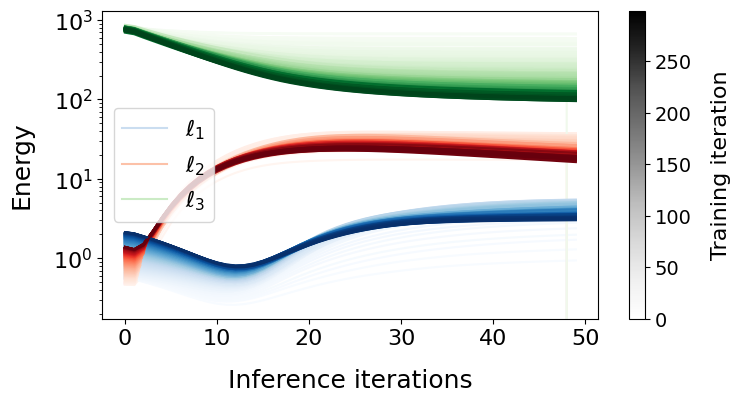

In [9]:
network, energies, ts = train(
    key=key,
    layer_sizes=LAYER_SIZES,
    batch_size=BATCH_SIZE,
    network=network,
    lr=LEARNING_RATE,
    t1=T1,
    n_train_iters=N_TRAIN_ITERS
)
plot_train_energies(energies, ts)